In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from Bayesian2 import BayesianLinearRegression

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYield,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8.0,3.0,2022-2,15.22,0.0000,...,1.135858,0.000000,1.820438,0,0,0,0,9.912500,50.478673,NaN
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8.0,4.0,2022-2,18.96,15.2200,...,1.091521,0.107655,1.589745,0,0,0,0,10.066667,53.841648,NaN
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8.0,5.0,2022-2,22.64,17.0900,...,1.091326,0.089176,1.894598,0,1,0,0,10.466667,52.935959,NaN
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8.0,6.0,2022-2,26.49,18.9400,...,1.121861,0.079936,2.877443,0,0,0,0,11.183333,52.872112,NaN
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8.0,7.0,2022-3,33.61,20.8275,...,1.290389,0.098152,7.563598,0,1,0,0,12.704167,56.056547,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628671,2022-03-19,f454e660,SE-fcdf259d-0044-0,3709,41 Fjällko,9.0,274.0,2022-2,20.41,12.4860,...,1.279380,0.020560,4.456955,0,0,0,0,3.866667,43.381437,NaN
628672,2022-03-20,f454e660,SE-fcdf259d-0044-0,3710,41 Fjällko,9.0,275.0,2022-2,12.17,12.8140,...,1.044928,0.051173,0.523270,0,0,0,0,2.450000,40.920659,NaN
628673,2022-03-21,f454e660,SE-fcdf259d-0044-0,3711,41 Fjällko,9.0,276.0,2022-2,13.59,13.4100,...,1.090977,0.051860,1.133279,0,0,0,0,3.170833,42.103862,NaN
628674,2022-03-22,f454e660,SE-fcdf259d-0044-0,3712,41 Fjällko,9.0,277.0,2022-2,13.20,14.0560,...,0.927500,-0.062114,-1.031801,0,0,0,0,4.691667,43.334997,NaN


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.965096,1.004827
1,2022-2,0.961104,1.005417
2,2022-3,0.963488,1.006825
3,2022-4,0.964590,1.007673
4,2023-1,0.960904,1.007640
5,2023-2,0.959833,1.007438
6,2023-3,0.964673,1.007370
7,2023-4,0.962260,1.007587
8,2024-1,0.964682,1.007672
9,2024-2,0.962310,1.007279


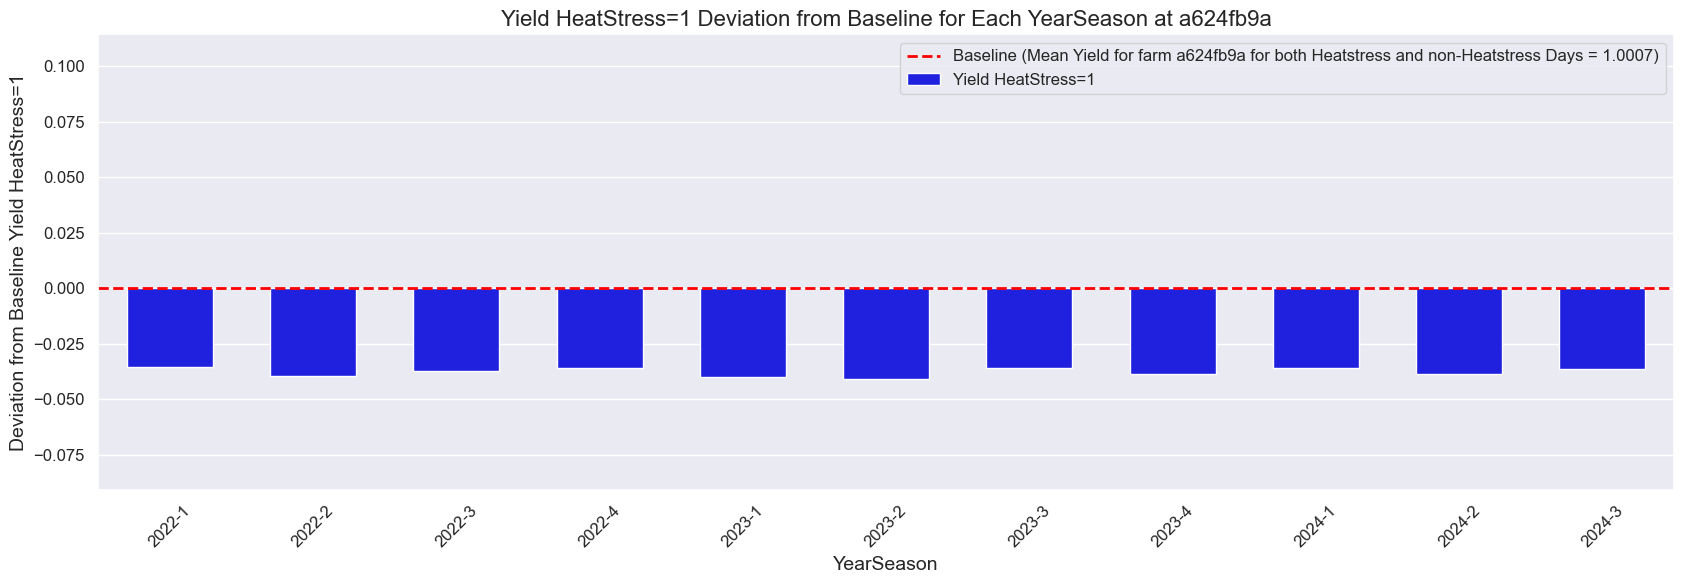

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.05, max(results_df['Deviation from Baseline HeatStress=1']) + 0.15)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

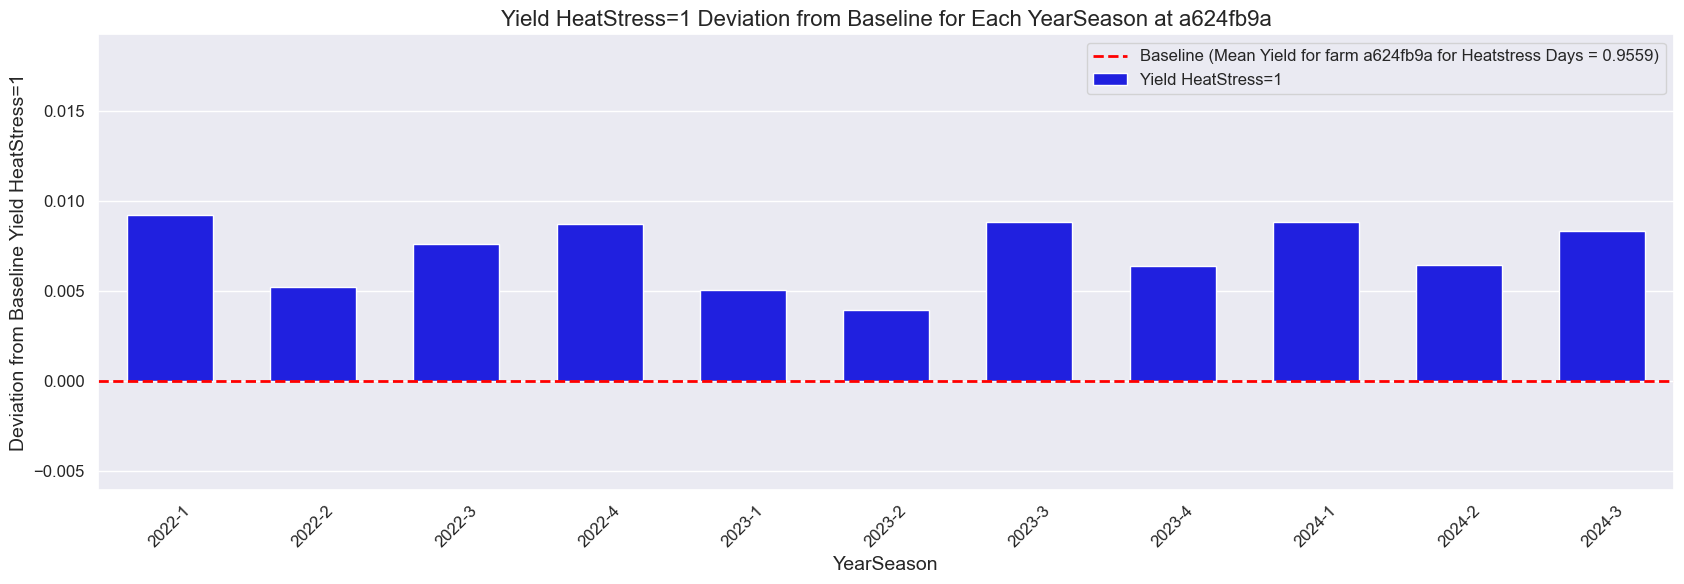

In [5]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm 5c06d92d

In [6]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.863041,1.004975
1,2022-2,0.863808,1.004878
2,2022-3,0.860370,1.005475
3,2022-4,0.860027,1.005410
4,2023-1,0.857597,1.005255
5,2023-2,0.845802,1.005553
6,2023-3,0.844820,1.005559
7,2023-4,0.850212,1.005404
8,2024-1,0.853689,1.005177
9,2024-2,0.855814,1.003853


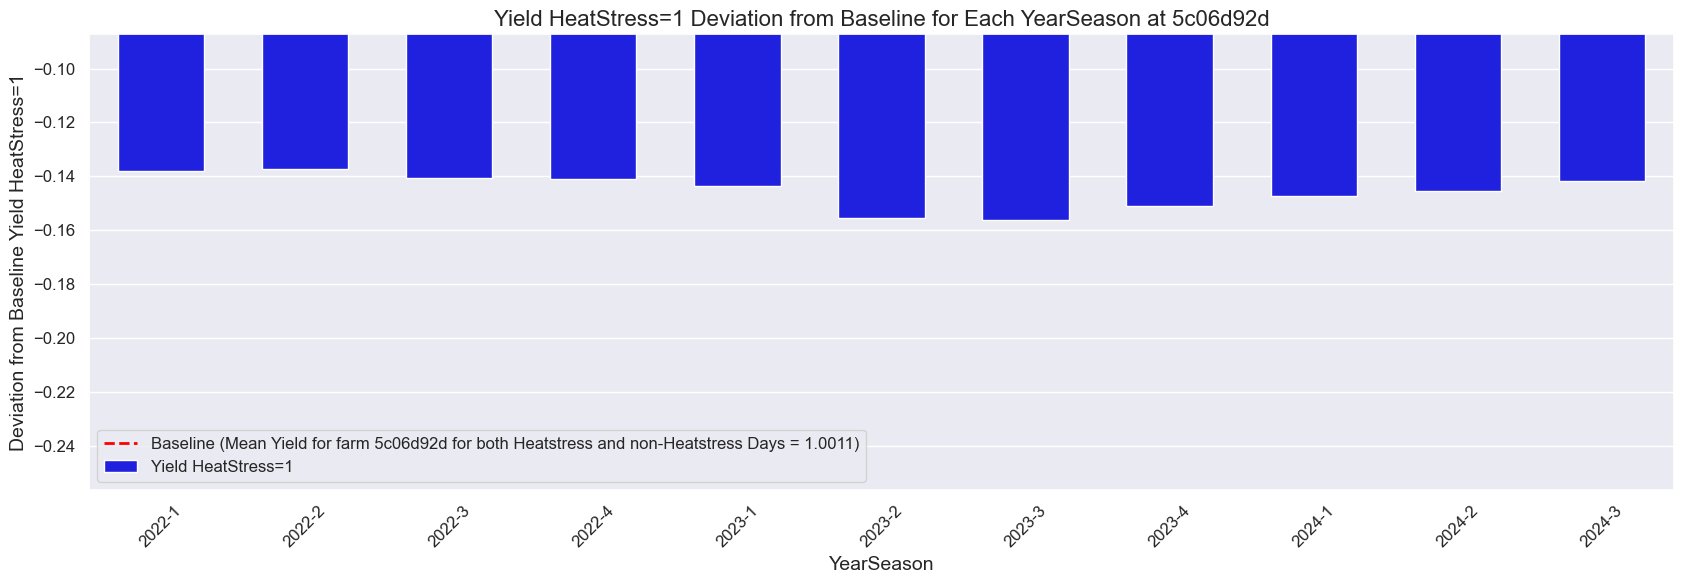

In [7]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.1, max(results_df['Deviation from Baseline HeatStress=1']) + 0.05)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

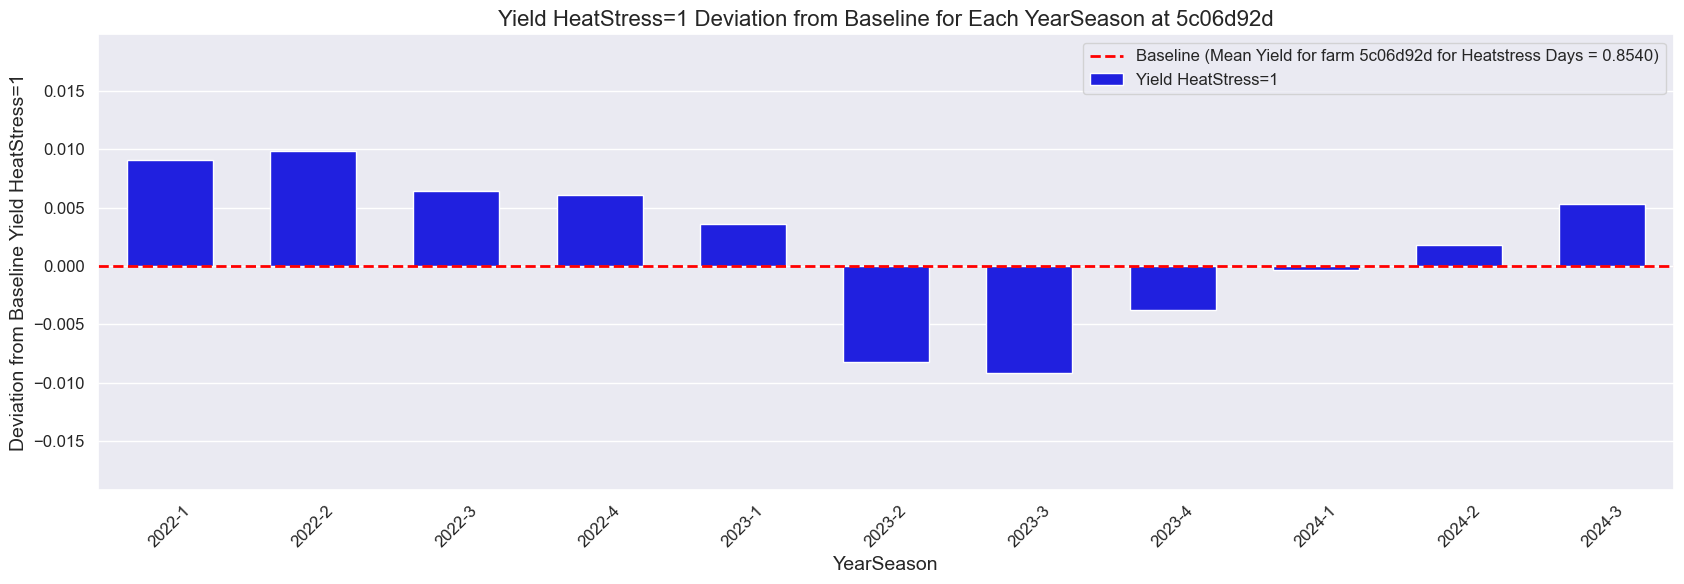

In [8]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm 752efd72

In [9]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.995309,1.006039
1,2022-2,1.009848,1.006557
2,2022-3,1.002302,1.006726
3,2022-4,0.996627,1.006769
4,2023-1,0.974074,1.007167
5,2023-2,0.976006,1.007244
6,2023-3,0.967142,1.006329
7,2023-4,0.961673,1.007184
8,2024-1,0.957468,1.006314
9,2024-2,0.953002,1.006525


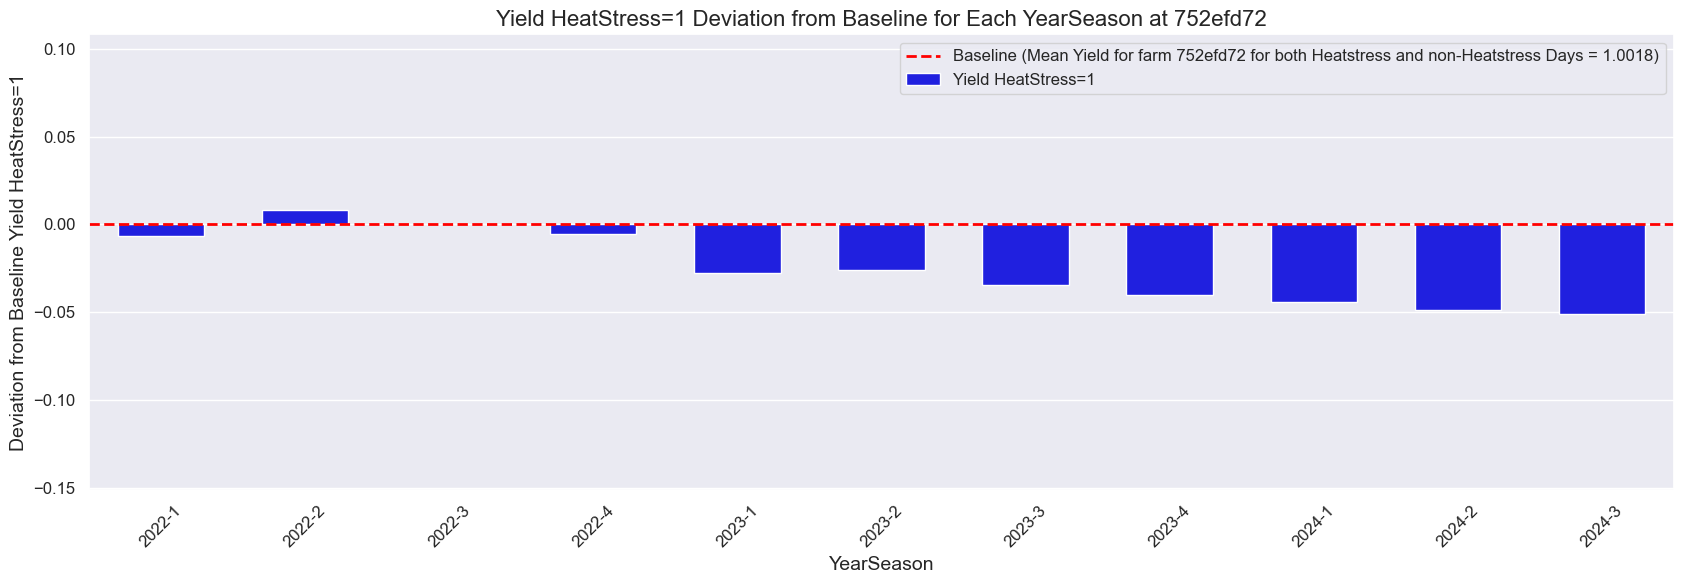

In [10]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.1, max(results_df['Deviation from Baseline HeatStress=1']) + 0.1)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

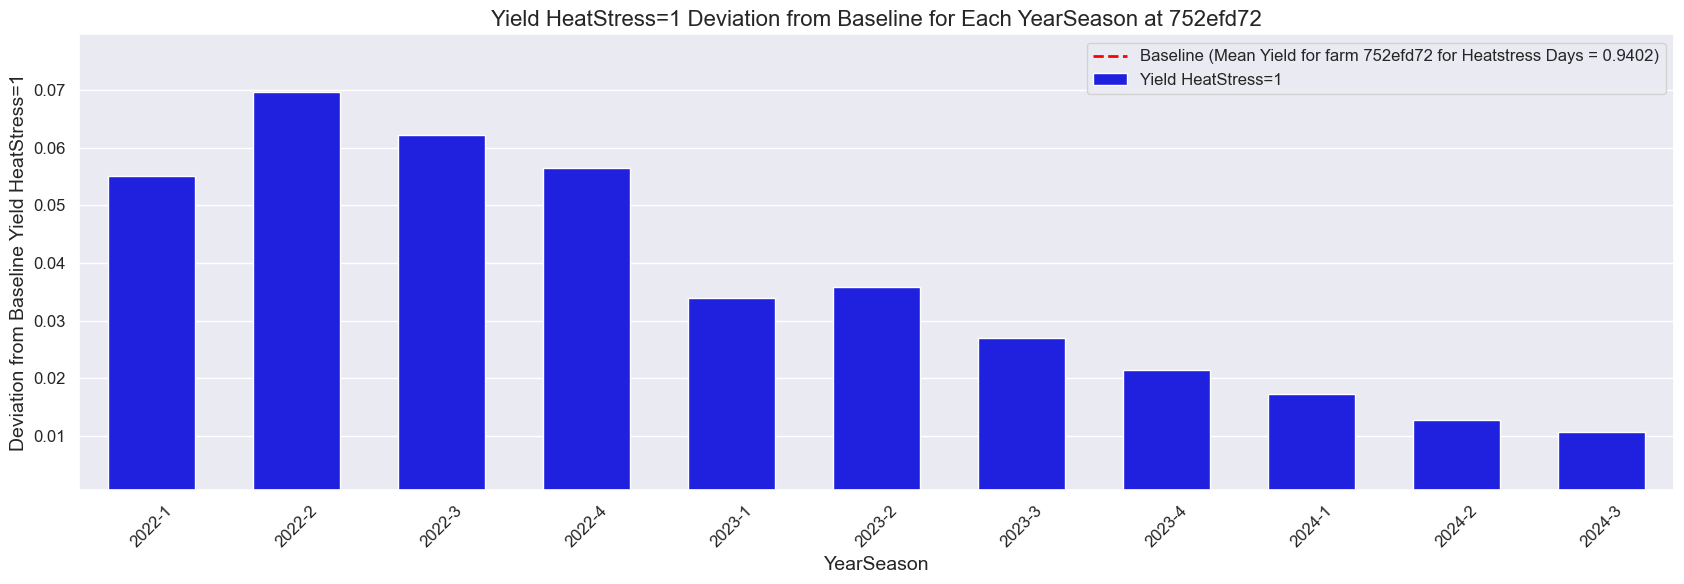

In [11]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm f454e660

In [12]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.958050,1.008736
1,2022-2,0.956867,1.008005
2,2022-3,0.960939,1.005746
3,2022-4,0.956447,1.006655
4,2023-1,0.967391,1.009266
5,2023-2,0.964574,1.008462
6,2023-3,0.976116,1.008983
7,2023-4,0.967398,1.009980
8,2024-1,0.969802,1.010406
9,2024-2,0.969593,1.009313


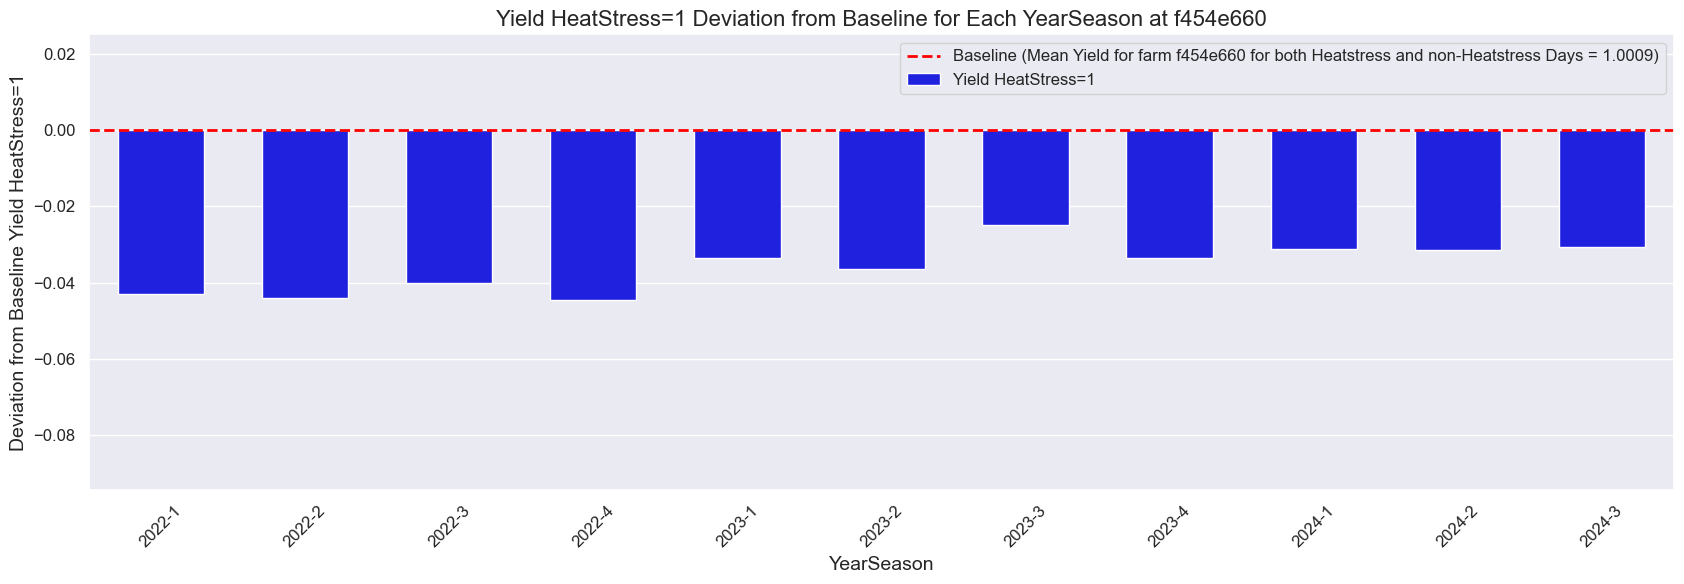

In [13]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.05, max(results_df['Deviation from Baseline HeatStress=1']) + 0.05)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

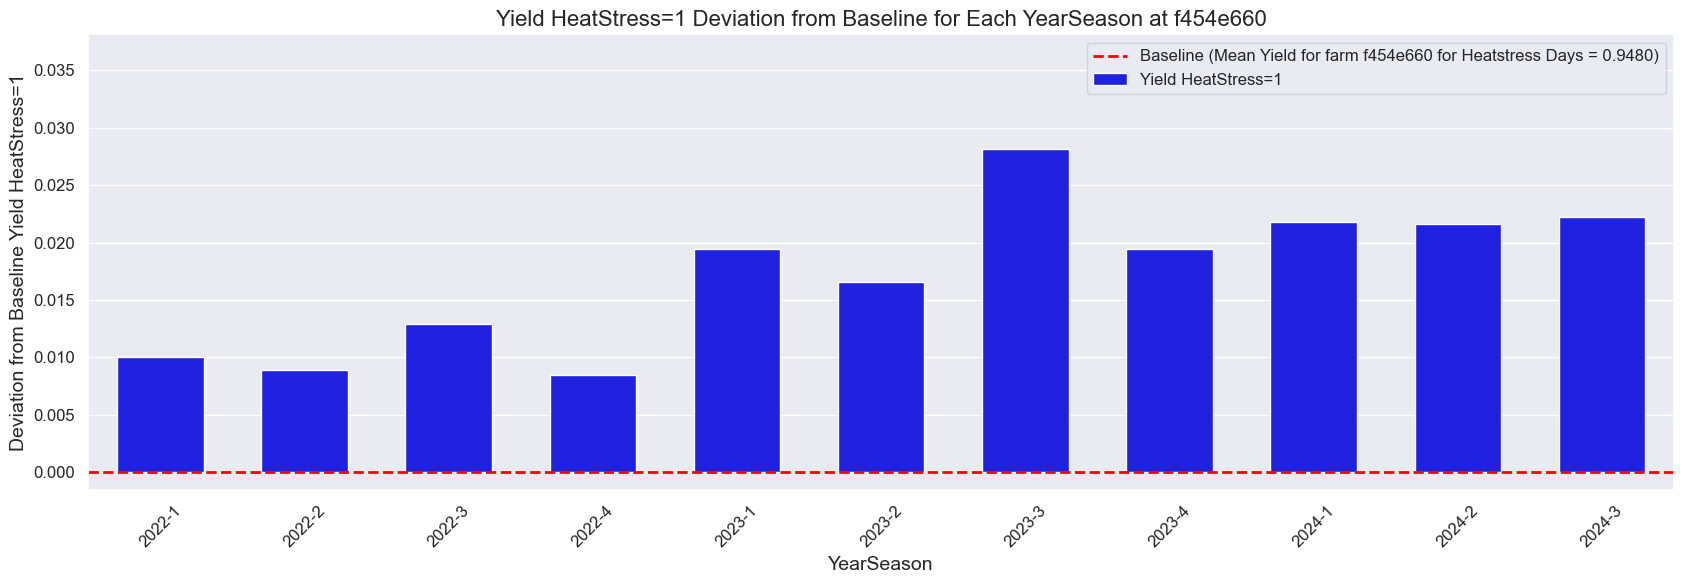

In [14]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()